In [2]:
import pydicom
from itertools import chain
import os
import numpy
from matplotlib import pyplot, cm
import cv2
import pandas as pd
from keras.utils import to_categorical, Sequence
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras import models
from keras import layers
from keras import optimizers

Using TensorFlow backend.


# 0 - Creation of train Dataset for cropped mass images and feature extraction

In [3]:
# Converts DICOM images in loss less JPEG and save them in a given folder. Possibility of image enhancement by CLAHE algorithm
def dicom_to_jpg(dicom_path, jpg_path, mass_calc, ENHANCE=True):
    if mass_calc=="MASS":
        prefix = "m_"
    elif mass_calc=="CALC":
        prefix = "c_"
    else:
        print("Missing mass_calc argument : set it on 'MASS' if dicom_path contains only \
            mass case, and 'CALC' if it contains only calcification cases ")
        return -1
    clahe1 = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(6,6)) #CLAHE for local contrast enhancing
    clahe2 = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    clahe3 = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(10,10))
    threshold1 = 250*250
    threshold2 = 400*400
    i = 0
    for dirName, subdirList, fileList in os.walk(dicom_path):
        for filename in fileList:
            path = os.path.join(dirName, filename)
            dic = pydicom.read_file(path)
            if (dic.SeriesDescription == "cropped images"):  # check whether the file's segmented image
                i_str = str(i)
                new_name = prefix + (5-len(i_str))*"0"+i_str+".jpg"
                pixels = dic.pixel_array
                size = pixels.size
                if ENHANCE:
                    if size<threshold1:
                        pixels = clahe1.apply(pixels) 
                    elif size<threshold2:
                        pixels = clahe2.apply(pixels)
                    else:
                        pixels = clahe3.apply(pixels)
                cv2.imwrite(os.path.join(jpg_path, new_name), pixels/256., [int(cv2.IMWRITE_JPEG_QUALITY), 100])
                i+=1
    return None

In [4]:
def dataframe_generator(path_file, mass_calc="", n_images=None):
    if mass_calc=="MASS":
        prefix = "m_"
    elif mass_calc=="CALC":
        prefix = "c_"
    else:
        prefix = ""
    full_data = pd.read_csv(path_file, sep=';', header=0)
    full_data.dropna(0, inplace=True, how='all') # Remove fully empty rows
    full_data.reset_index(drop=True, inplace=True)
    descriptions = full_data.pathology.copy()
    if n_images==None:
        n_images = descriptions.shape[0]
    descriptions[descriptions == 'BENIGN_WITHOUT_CALLBACK'] = 'BENIGN' # Replace all 'benign without callback' by 'benign'
    paths = [[prefix+(5-len(str(i)))*"0"+str(i)+".jpg"] for i in range(n_images)]
    paths = pd.DataFrame(data=paths, columns=['filename'])
    df = pd.concat([paths, descriptions[:n_images]], axis=1)
    return df

In [33]:
def extract_features(dataframe, directory, sample_count, subset):
    features = numpy.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = numpy.zeros(shape=(sample_count, 2))
    # Preprocess data
    generator = datagen.flow_from_dataframe(
        dataframe=dataframe, 
        directory=directory, 
        x_col="filename", y_col="pathology", class_mode="categorical",
        target_size=(224,224), 
        batch_size=batch_size, shuffle=True, 
        interpolation="bilinear",
        subset=subset,
        classes = ['BENIGN', 'MALIGNANT'])
    # Pass data through convolutional base
    print("MAP : ", generator.class_indices)
    i = 0
    inputs_batch, labels = next(generator)
    features = conv_base.predict(inputs_batch)
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features = numpy.concatenate((features, features_batch), axis=0)
        labels = numpy.concatenate((labels, labels_batch), axis=0)
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [6]:
# Computes the total number of samples used for training phase after augmentation
def compute_num_samples(data_size, validation_ratio, aug_factor):
    train_size = int((1-validation_ratio) * data_size * aug_factor)
    return train_size

In [38]:
path_mixed = "./../CBIS-DDSM/Mix_crop_mask/CBIS-DDSM/" # Don't forget to change the paths if necessary
path_crop = "./../CBIS-DDSM/Cropped_mammo_jpg/"
path_labels = "./../CBIS-DDSM/mass_case_description_train_set.csv"
#dicom_to_jpg(path_mixed, path_crop, "MASS")
valid_ratio = 0.2
batch_size = 32
augmentation = 3
df = dataframe_generator(path_labels, 'MASS')
data_size = df.shape[0]
train_size = compute_num_samples(data_size, valid_ratio, augmentation)

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

datagen = ImageDataGenerator(
         rescale=1/255.,
         vertical_flip=True,
         horizontal_flip=True, 
         validation_split=valid_ratio)

train_features, train_labels = extract_features(df, path_crop, train_size, "training")  # Agree with our small dataset size

ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[node block5_conv3_3/random_uniform/min (defined at C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\keras\backend\tensorflow_backend.py:4139) ]]

Caused by op 'block5_conv3_3/random_uniform/min', defined at:
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\asyncio\base_events.py", line 438, in run_forever
    self._run_once()
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\asyncio\base_events.py", line 1451, in _run_once
    handle._run()
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\tornado\gen.py", line 781, in inner
    self.run()
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\tornado\gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\IPython\core\interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\IPython\core\interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\IPython\core\interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\IPython\core\interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-38-fc948c5e902b>", line 12, in <module>
    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\keras\applications\__init__.py", line 28, in wrapper
    return base_fun(*args, **kwargs)
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\keras\applications\vgg16.py", line 11, in VGG16
    return vgg16.VGG16(*args, **kwargs)
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\keras_applications\vgg16.py", line 172, in VGG16
    name='block5_conv3')(x)
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\keras\engine\base_layer.py", line 431, in __call__
    self.build(unpack_singleton(input_shapes))
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\keras\layers\convolutional.py", line 141, in build
    constraint=self.kernel_constraint)
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\keras\engine\base_layer.py", line 249, in add_weight
    weight = K.variable(initializer(shape),
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\keras\initializers.py", line 218, in __call__
    dtype=dtype, seed=self.seed)
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\keras\backend\tensorflow_backend.py", line 4139, in random_uniform
    dtype=dtype, seed=seed)
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\tensorflow\python\ops\random_ops.py", line 240, in random_uniform
    minval = ops.convert_to_tensor(minval, dtype=dtype, name="min")
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\tensorflow\python\framework\ops.py", line 1039, in convert_to_tensor
    return convert_to_tensor_v2(value, dtype, preferred_dtype, name)
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\tensorflow\python\framework\ops.py", line 1097, in convert_to_tensor_v2
    as_ref=False)
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\tensorflow\python\framework\ops.py", line 1175, in internal_convert_to_tensor
    ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\tensorflow\python\framework\constant_op.py", line 304, in _constant_tensor_conversion_function
    return constant(v, dtype=dtype, name=name)
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\tensorflow\python\framework\constant_op.py", line 245, in constant
    allow_broadcast=True)
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\tensorflow\python\framework\constant_op.py", line 289, in _constant_impl
    name=name).outputs[0]
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [] and type float
	 [[node block5_conv3_3/random_uniform/min (defined at C:\Users\Utilisateur\Anaconda3\envs\tens\lib\site-packages\keras\backend\tensorflow_backend.py:4139) ]]


In [8]:
vgg = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

553467904/553467096 [==============================] - 2817s 5us/step


In [9]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [ ]:
valid_size = compute_num_samples(data_size, 1-valid_ratio, 1)
validation_features, validation_labels = extract_features(df, path_crop, valid_size, "validation")  # Agree with our small dataset size

In [9]:
numpy.save("validation_labels", validation_labels)
numpy.save("validation_features", validation_features)
numpy.save("train_features", train_features)
numpy.save("train_labels", train_labels)

In [3]:
validation_labels = numpy.load("validation_labels.npy")
validation_features = numpy.load("validation_features.npy")
train_features = numpy.load("train_features.npy")
train_labels = numpy.load("train_labels.npy")

In [46]:
path_test_mass_jpg = "./../CBIS-DDSM/crop_test_mass_jpg/"

## 1 - Classifier : Dense Neural Network

In [ ]:
epochs = 40

model = models.Sequential()
model.add(layers.Flatten(input_shape=(7,7,512)))
model.add(layers.Dense(256, activation='relu', input_dim=(7*7*512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))
model.summary()

# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])
              
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

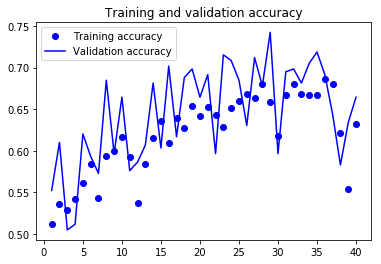

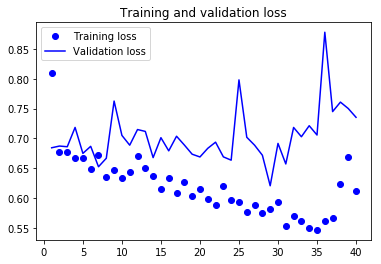

In [27]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend() 

plt.show()

In [28]:
from keras.preprocessing import image
def compute_predicitons(classifier, path_test_jpg, df_test_labels):
    n_img = df_test_labels.shape[0]
    c_fp = 0.
    c_fn = 0.
    c_tp = 0.
    c_tn = 0.
    for index, row in df_test_labels.iterrows():
        img_path = os.path.join(path_test_jpg, row.filename)
        img = image.load_img(img_path, target_size=(224, 224))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        # Extract features
        features = conv_base.predict(img_tensor.reshape(1,224, 224, 3))
        
        # Make prediction
        try:
            prediction = classifier.predict(features)
        except:
            print("Bizarre")
            prediction = classifier.predict(features.reshape(1, 7*7*512))
        #print(prediction)
        if prediction < 0.5:
            if row.pathology == "BENIGN":
                c_tn += 1
            else:
                c_fn += 1
        else:
            if row.pathology == "BENIGN":
                c_fp += 1
            else:
                c_tp += 1
    return (c_tp+c_tn)/n_img, c_fp/(c_fp+c_tp)  

In [29]:
path_labels_test = "./../CBIS-DDSM/mass_case_description_test_set.csv"
path_mass_test_jpg = "./../CBIS-DDSM/crop_test_mass_jpg/"
df_test = dataframe_generator(path_labels_test, None)
acc, fprate = compute_predicitons(model, path_mass_test_jpg, df_test)
print(acc, fprate)

0.7063492063492064 0.22727272727272727


## 2 - Classifier : Global Average Pooling

In [ ]:
# Define model
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

model = models.Sequential()
model.add(layers.GlobalAveragePooling2D(input_shape=(7,7,512)))
model.add(layers.Dense(2, activation='sigmoid'))
model.summary()

# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])
              
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

In [10]:
svm_labels[:10]

array([1., 1., 0., 1., 0., 0., 1., 0., 1., 1.], dtype=float32)

In [41]:
#svm_features[numpy.where(svm_features>1)] = 1
print(numpy.where(svm_features>1))
svm_features.shape

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


(3228, 7, 7, 512)

## 3 - Classifier : Linear SVM

In [97]:
# Concatenate training and validation sets
svm_features = numpy.concatenate((train_features, validation_features))
svm_labels = numpy.concatenate((train_labels, validation_labels))

In [ ]:
net_output_train = model.predict(train_features)
net_output_val = model.predict(validation_features)


In [24]:
bal = numpy.array([[3,4, 5,6], [8,10, 14,56], [0,-5,63,2]])
scaler = StandardScaler(copy=True)
scaler.fit(bal)
print(scaler)
bal = scaler.transform(bal, copy=True)
bal

StandardScaler(copy=True, with_mean=True, with_std=True)


array([[-0.20203051,  0.16222142, -0.87628504, -0.62413416],
       [ 1.31319831,  1.13554995, -0.52315525,  1.41108592],
       [-1.1111678 , -1.29777137,  1.39944029, -0.78695176]])

In [11]:
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [13]:
a = numpy.array([[1,5,8],[7,5,4],[7,8,1]])

In [ ]:
# Build model
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

X_train, y_train = svm_features[:3000].reshape(3000,7*7*512), svm_labels[:3000]

param = [{
          "C": [0.01, 0.1, 1, 10, 100]
         }]

svm = LinearSVC(penalty='l1', loss='squared_hinge')  # As in Tang (2013)
clf = GridSearchCV(svm, param, cv=10)
print("Hello")
clf.fit(X_train, y_train)

In [1]:
# Evaluate model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

print("\nAccuracy score (mean):")
print(numpy.mean(cross_val_score(clf, X_train[:100], y_train[:100], cv=10)))
print("\nAccuracy score (standard deviation):")
print(numpy.std(cross_val_score(clf, X_train[:100], y_train[:100], cv=10)))


Accuracy score (mean):


NameError: name 'numpy' is not defined